#  **ICT303 - Assignment 1**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>**

**Email: <enter here your email address>**






## **1. Description**

In this homework, you will build, train, test and compare the performance of multilayer perceptrons (MLP) and convolutional neural networks (CNNs) on a multi-class classification problem.

For this task, you will use the image dataset available [here](https://drive.google.com/file/d/1nWRm-Npq_QE0j_sHyVVxVEx2Rb0Lc1zU/view?usp=sharing). This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):




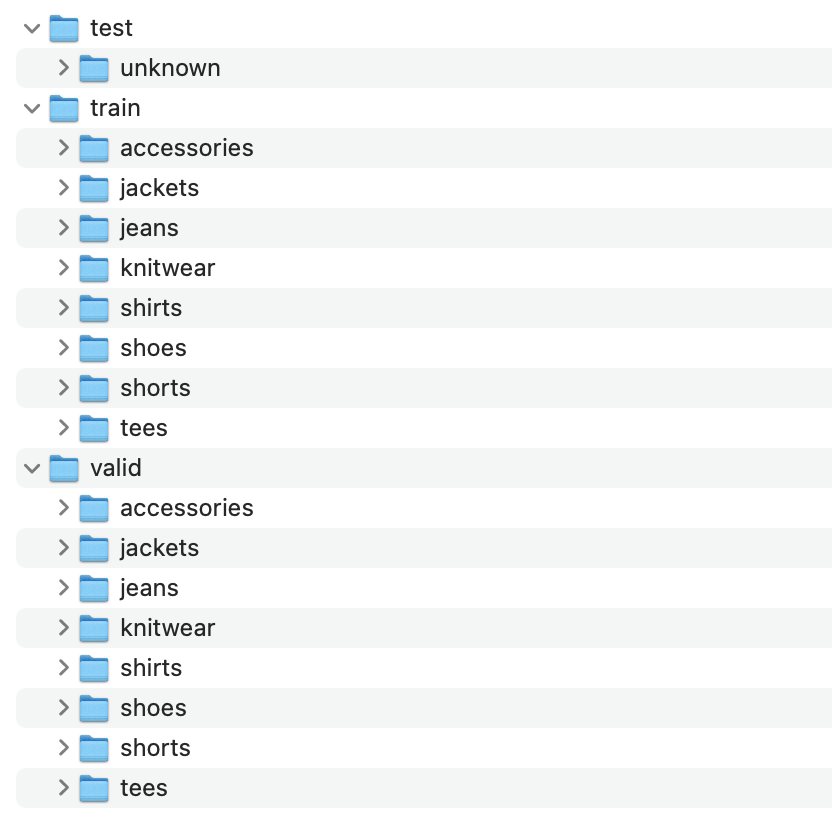


Your task is to:
1. Develop a multilayer perceptron model, train it and test it on the dataset. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
2. Implement VGG16, which a CNN architecture, train it and test it on the dataset. You must NOT use the pre-implemented VGG16 network in Pytorch. Instead, you have to implement all the layers and blocks yourself from scratch. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
3. Repeat step 2 above , but this time using the pretrained VGG16 network of PyTorch. **[20 Marks]**
4. For each of the tasks above, you need to finetune the hyper parameters to achieve the best performance possible.
5. Compare the performance of the three models.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

For Perth campus students, enrolled in internal model, you will be required to demonstrate your work in class. External students may be called to demonstrate the work to their tutor.

## **2. What do you need to submit**

You must submit:
- your source code, in the form of python libraries (i.e., .py files)
- A colab notebook that
 - Describes your solution and design choices. It is highly recommended to visually show the architecture of the networks you developed. You must include a discussion on how the hyper parameters affect performance and how did you select the ones you are currently using.
 - Demonstrates the training and testing of the machine learning models you developed.
 - Plots the training and validation curves for each model. You are requried to use TensorBoard for this task.
 - Analyzes the performance, in terms of Confusion Matrix and Mean Average Precision (MAE), of the methods, and how the hyper parameters affect this performance.
 - Allows the visualization of some classification results.

Important notes
- The performance of the machine learning models can be significantly affected by (1) the amount of data on which they are traiined, and (2) preprocessing, such as normalization, of the data (I will talk about this in class).
- Your program must be structured following what we have seen in the labs. In other words, you must use Object-oriented Programming and have a class for the data, a class for the model, a class for the trainer. You are allowed to reuse code you create in the labs. Also, you are allowed (in fact sometimes you should) reuse code across different models. For example, you only need one class to manage the data, whether you are using MLPs or CNNs (VGG16 in our case).
- We have zero tolerance for plagaiarsism and misconduct (e.g., asking AI to do the work for you).


In [29]:
# prompt: check if I have a gpu via pytorch

import torch

print(torch.cuda.is_available())

True


My own VGG16 implementation:

Import Dependencies

In [30]:
import os # for some OS ops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder # The data set that we will use
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
print("Dependencies Loaded!")

Dependencies Loaded!


In [31]:
!git clone https://github.com/Aithusa712/GoogleColab.git
%cd GoogleColab/Assignment\ 1   # linux os
%cd "GoogleColab/Assignment 1"  # windows os
print("Data downloaded!")

Cloning into 'GoogleColab'...
remote: Enumerating objects: 4006, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 4006 (delta 5), reused 0 (delta 0), pack-reused 3990 (from 2)
Receiving objects: 100% (4006/4006), 58.48 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (64/64), done.
[Errno 2] No such file or directory: 'GoogleColab/Assignment 1 # linux os'
/content
[Errno 2] No such file or directory: 'GoogleColab/Assignment 1 # windows os'
/content
Data downloaded!


In [32]:
%cd GoogleColab/Assignment\ 1
%cd "GoogleColab/Assignment 1"

/content/GoogleColab/Assignment 1
[Errno 2] No such file or directory: 'GoogleColab/Assignment 1'
/content/GoogleColab/Assignment 1


Load tensorboard

In [33]:
%load_ext tensorboard
print("tensorboard extension loaded")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
tensorboard extension loaded


MLP class implementation based on MLP architecture
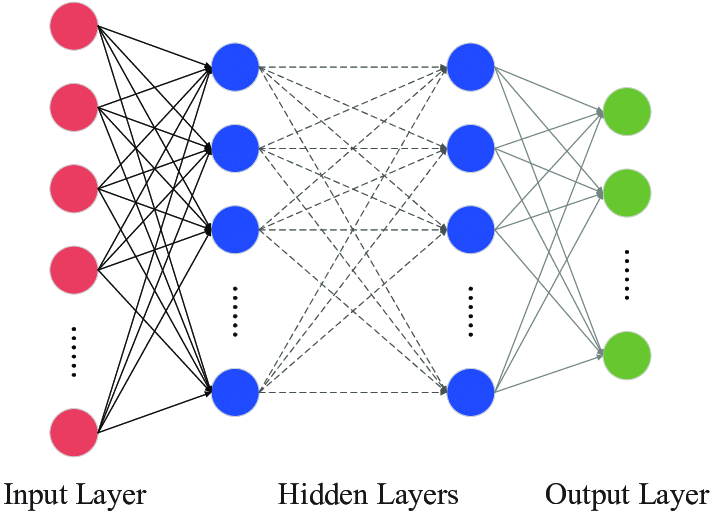

In [34]:
## The MLP class
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, inputSize=224 * 224 * 3, outputSize=8, lr=0.01, class_weights=None):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        # Input and First hidden Layer
        nn.Linear(inputSize, 512),
        nn.ReLU(),

        # Second hidden Layer
        nn.Linear(512, 128),
        nn.ReLU(),

        # Output Layer
        nn.Linear(128, outputSize),
    )
    # Setting the learning rate
    self.lr = lr
    # Setting the class weights
    self.class_weights = class_weights

  ## The forward step
  def forward(self, X):
    # Computes the output given the input X
    return self.layers(X)

  ## The loss function - Here, we will use Cross Entropy Loss
  def loss(self, y_hat, y):
    fn = nn.CrossEntropyLoss(weight=self.class_weights)
    return fn(y_hat, y)

  ## The optimization algorithm
  def configure_optimizers(self):
    # return torch.optim.SGD(self.parameters(), self.lr)
    return torch.optim.Adam(self.parameters(), self.lr)


myVGG16 class implementation based on VGG16 Architecture
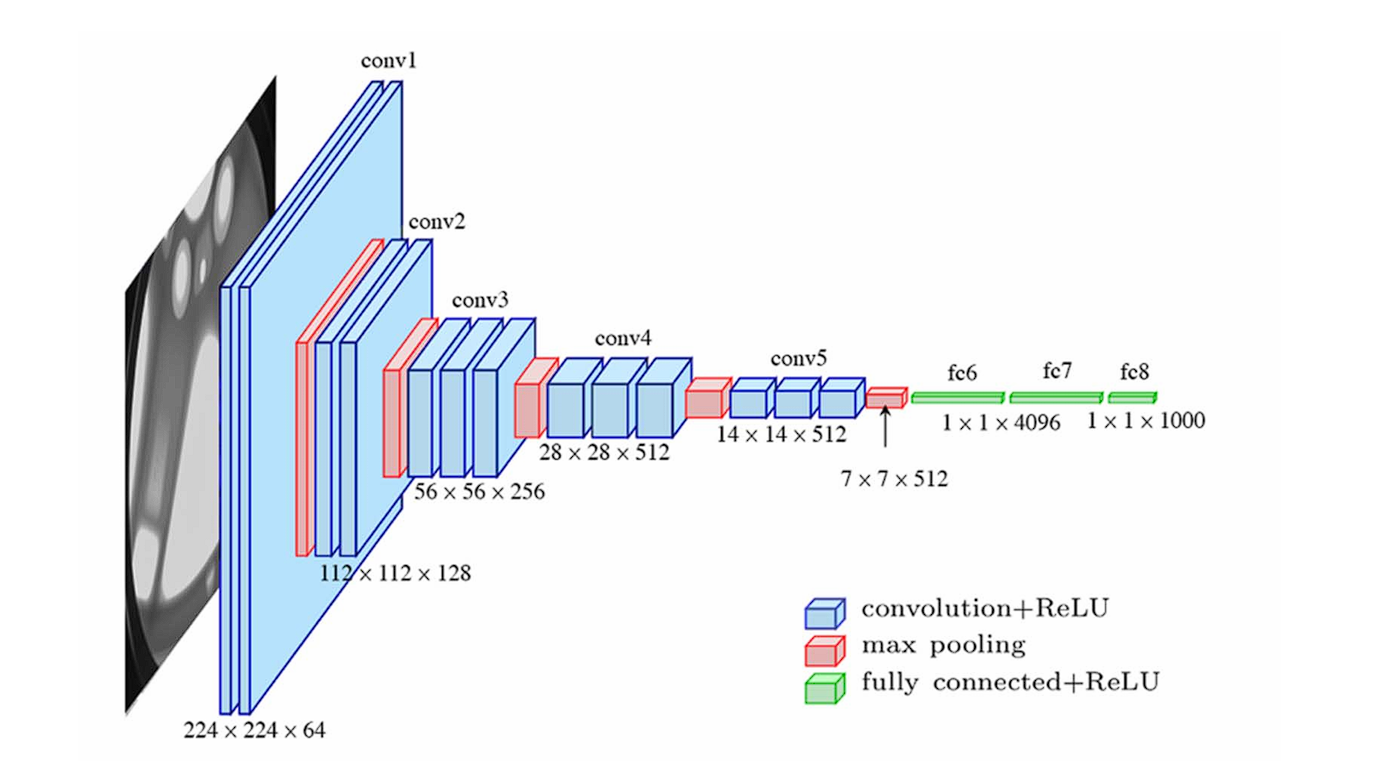

In [35]:
class myVGG16(nn.Module):
    def __init__(self, outputSize=8, lr=1e-3, class_weights=None):
        super().__init__()

        # VGG-16 feature blocks
        self.features = nn.Sequential(
            #conv1
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),        # Convolution + ReLU
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),       # Convolution + ReLU
            #conv2
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),      # Convolution + ReLU
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            #conv3
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            #conv4
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU


            # conv5
            nn.MaxPool2d(2, 2),                                           # Max Pooling
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU

            nn.MaxPool2d(2, 2),                                           # Max Pooling
        )

        # For 224x224 input
        self.classifier = nn.Sequential(
          # fc6
          nn.Linear(512 * 7 * 7, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          # fc7
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          # fc8
          nn.Linear(4096, outputSize)
        )

        self.lr = lr
        self._init_weights()
        self.class_weights = class_weights

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

    def loss(self, y_hat, y):
       return nn.CrossEntropyLoss(weight=self.class_weights)(y_hat, y)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

Training Class

In [36]:
class Trainer:

  def __init__(self, tb, n_epochs = 3):
    self.max_epochs = n_epochs
    self.writer = tb  # the tensorboard instance
    return

  def fit(self, model, data, validation_data):
    self.data = data
    self.validation_data = validation_data

    # configure the optimizer
    self.optimizer = model.configure_optimizers()
    self.model     = model

    for epoch in range(self.max_epochs):
      print(f"\n🔁 Epoch {epoch + 1}/{self.max_epochs}")
      self.fit_epoch()
      self.validate_epoch()

      # Logging the average training loss so that it can be visualized in the tensorboard
      self.writer.add_scalar("Training Loss", self.avg_training_loss, epoch)
      self.writer.add_scalar("Validation Loss", self.avg_val_loss, epoch)

    print("Training process has finished")

  def fit_epoch(self):

    self.model.train()
    current_loss = 0.0
    self.avg_training_loss = 0.0

    # iterate over the DataLoader for training data
    for i, data in enumerate(self.data):
      # Get input
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device) # use GPU


      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t to the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statistics (average of the training loss over minibatches of 500 data items)
      current_loss += loss.item()

      # Adding training loss
      self.avg_training_loss += loss.item()

      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    # The average training loss
    self.avg_training_loss = self.avg_training_loss / i # to get the average
    print(f"Training Loss (avg): {self.avg_training_loss:.4f}")

  def validate_epoch(self):

    self.model.eval()
    total_loss = 0.0
    self.avg_val_loss = 0.0

    with torch.no_grad():
      # iterate over the DataLoader for training data
      for i, data in enumerate(self.validation_data):
        # Get input
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device) # use GPU

        # get output from the model, given the inputs
        outputs = self.model(inputs)

        # get loss for the predicted output
        loss = self.model.loss(outputs, target)

        total_loss += loss.item()

      # The average training loss
      self.avg_val_loss = total_loss / (i + 1) # to get the   average
      print(f"Validation Loss (avg): {self.avg_val_loss:.4f}")

Load images into preprocessed data (fixes a problem with slow training for my setup)

In [37]:
class DataManager:
    def __init__(self, train_dir="data/train", val_dir="data/valid", image_size=(224, 224)):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        # Load datasets with ImageFolder
        train_dataset = ImageFolder(root=self.train_dir, transform=self.transform)
        val_dataset = ImageFolder(root=self.val_dir, transform=self.transform)

        # Extract and save training data
        train_images, train_labels = zip(*[(img, label) for img, label in train_dataset])
        train_images = torch.stack(train_images)
        train_labels = torch.tensor(train_labels)
        torch.save((train_images, train_labels), "train_tensor.pt")

        # Extract and save validation data
        val_images, val_labels = zip(*[(img, label) for img, label in val_dataset])
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        torch.save((val_images, val_labels), "val_tensor.pt")

        # Save class names
        with open("classes.txt", "w") as f:
            for class_name in train_dataset.classes:
                f.write(f"{class_name}\n")

    def load_data(self):
        train_images, train_labels = torch.load("train_tensor.pt")
        val_images, val_labels = torch.load("val_tensor.pt")
        with open("classes.txt", "r") as f:
            class_names = [line.strip() for line in f]
        return train_images, train_labels, val_images, val_labels, class_names

    def get_class_weights(self, labels, num_classes, device):
        label_counts = Counter(labels.tolist())
        class_weights = [(1 / label_counts[i]) ** 0.5 for i in range(num_classes)]
        return torch.tensor(class_weights, dtype=torch.float).to(device)

Main Program

In [40]:
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 32
    n_epochs = 7
    lr = 3e-4
    writer = SummaryWriter('runs/custom_dataset')

    # Prepare / Load Data
    data_manager = DataManager()

    # Only run once unless you want to regenerate files
    data_manager.prepare_data()

    train_images, train_labels, val_images, val_labels, class_names = data_manager.load_data()

    # Create Datasets and DataLoaders
    train_dataset = TensorDataset(train_images, train_labels)
    val_dataset = TensorDataset(val_images, val_labels)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Compute class weights
    num_classes = len(class_names)
    class_weights = data_manager.get_class_weights(train_labels, num_classes, device)

    # Initialize Model (Choose one)
    mlp_model = MLP(outputSize=num_classes, lr=lr, class_weights=class_weights).to(device)
    myVGG16_model = myVGG16(outputSize=num_classes, lr=lr, class_weights=class_weights).to(device)

    # Train
    trainer = Trainer(writer, n_epochs)
    trainer.fit(mlp_model, train_loader, val_loader)
    trainer.fit(myVGG16_model, train_loader, val_loader)

    writer.close()
    print("Training complete.")

Using device: cuda

🔁 Epoch 1/7
Training Loss (avg): 1.4503
Validation Loss (avg): 0.8133

🔁 Epoch 2/7
Training Loss (avg): 0.7367
Validation Loss (avg): 0.8191

🔁 Epoch 3/7
Training Loss (avg): 0.5474
Validation Loss (avg): 0.6238

🔁 Epoch 4/7
Training Loss (avg): 0.4259
Validation Loss (avg): 0.6642

🔁 Epoch 5/7
Training Loss (avg): 0.3955
Validation Loss (avg): 0.6937

🔁 Epoch 6/7
Training Loss (avg): 0.3167
Validation Loss (avg): 0.7098

🔁 Epoch 7/7
Training Loss (avg): 0.2887
Validation Loss (avg): 0.8252
Training process has finished

🔁 Epoch 1/7
Training Loss (avg): 1.7714
Validation Loss (avg): 0.8195

🔁 Epoch 2/7
Training Loss (avg): 0.7327
Validation Loss (avg): 0.5005

🔁 Epoch 3/7
Training Loss (avg): 0.5521
Validation Loss (avg): 0.4599

🔁 Epoch 4/7
Training Loss (avg): 0.4309
Validation Loss (avg): 0.3287

🔁 Epoch 5/7
Training Loss (avg): 0.3409
Validation Loss (avg): 0.2914

🔁 Epoch 6/7
Training Loss (avg): 0.2843
Validation Loss (avg): 0.3284

🔁 Epoch 7/7
Training Loss (

In [ ]:
tensorboard --logdir runs

In [42]:
def evaluate_accuracy(model, dataloader, class_names=None):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"{accuracy:.2f}%")
    return
print("MLP Model 7 Epochs")
print("Training Accuracy:")
evaluate_accuracy(mlp_model, train_loader)
print("Validation Accuracy:")
evaluate_accuracy(mlp_model, val_loader)

print("VGG16 Model 7 Epochs")
print("Training Accuracy:")
evaluate_accuracy(myVGG16_model, train_loader)
print("Validation Accuracy:")
evaluate_accuracy(myVGG16_model, val_loader)



MLP Model 7 Epochs
Training Accuracy:
90.86%
Validation Accuracy:
77.75%
VGG16 Model 7 Epochs
Training Accuracy:
91.61%
Validation Accuracy:
89.27%


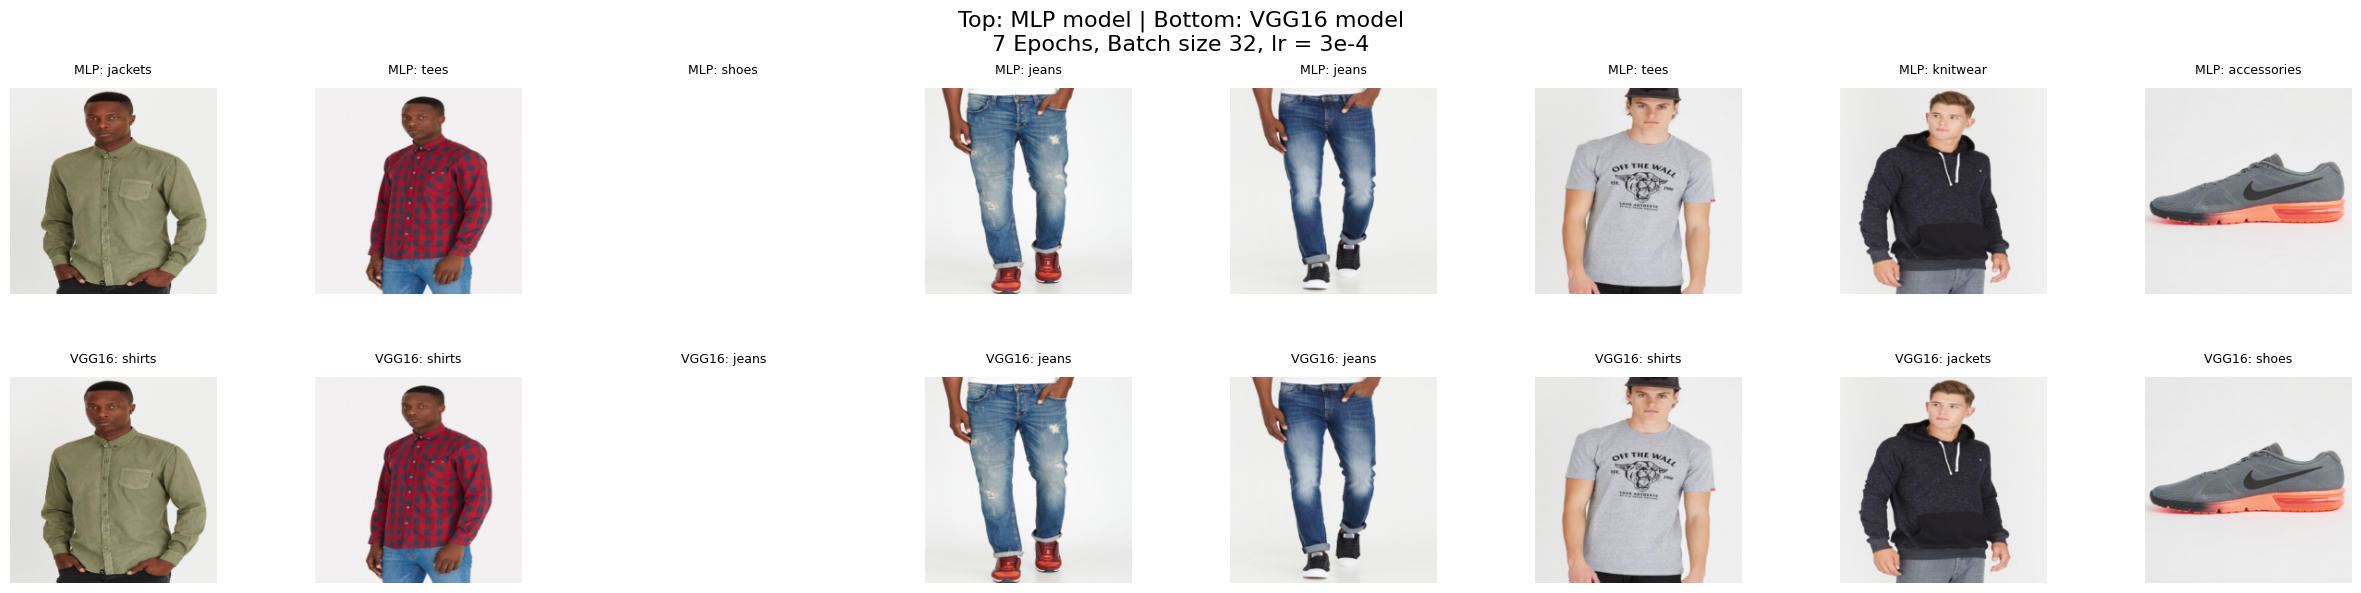

In [54]:
# Set models to evaluation mode
mlp_model.eval()
myVGG16_model.eval()

# Create figure with 2 rows and 8 columns
fig, axs = plt.subplots(2, 8, figsize=(24, 6))
fig.suptitle("Top: MLP model | Bottom: VGG16 model\n7 Epochs, Batch size 32, lr = 3e-4", fontsize=16)

# Collect 8 test images
test_images = []
with torch.no_grad():
    for inputs, _ in test_loader:
        for img in inputs:
            test_images.append(img)
            if len(test_images) == 8:
                break
        if len(test_images) == 8:
            break

# Stack and move to device
inputs = torch.stack(test_images).to(device)

# Get predictions
with torch.no_grad():
    outputs_mlp = mlp_model(inputs)
    outputs_vgg = myVGG16_model(inputs)

_, predicted_mlp = torch.max(outputs_mlp, 1)
_, predicted_vgg = torch.max(outputs_vgg, 1)

# Plot each image and predictions
for i in range(8):
    img = inputs[i].cpu() * 0.5 + 0.5  # unnormalize
    img_np = img.permute(1, 2, 0).numpy()

    # MLP (Top row)
    axs[0, i].imshow(img_np)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"MLP: {class_names[predicted_mlp[i].item()]}", fontsize=9, pad=10)

    # VGG16 (Bottom row)
    axs[1, i].imshow(img_np)
    axs[1, i].axis('off')
    axs[1, i].set_title(f"VGG16: {class_names[predicted_vgg[i].item()]}", fontsize=9, pad=10)

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.4)  # Added hspace and wspace
plt.show()
